In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
experiment_path = Path("experiments")
visualizations_path = Path("visualizations")
suffix = "fewshotevaend2end"
score_column = "knn_accuracy"  # column to plot

### 1. Combine CSVs

In [ ]:
# find all subdirectories in the experiment path
subdirs = [d for d in experiment_path.iterdir() if d.is_dir()]

# filter subdirectories to not contain _fewshot
subdirs = [d for d in subdirs if d.name.endswith(suffix) or 'fewshot' not in d.name]

# read the "combined_results.csv" file in each subdirectory
combined_df_list = []
for subdir in subdirs:
    combined_results = subdir / "combined_results.csv"
    if not combined_results.exists():
        continue
    df = pd.read_csv(combined_results)

    print(f"Processing {combined_results} with {len(df)} rows")

    # create a new column 'experiment'
    df["experiment"] = df.apply(
        lambda row: "base" if row["text_column"] == "text" and not row["instruction"]
        else "base+inst" if row["text_column"] == "text"
        else f"{row['text_column'].split("-")[1]}" if not row["instruction"] and "-" in row["text_column"]
        else f"{row['text_column'].split("-")[1]}+inst" if "-" in row["text_column"]
        else f"{row['text_column']}" if not row["instruction"]
        else f"{row['text_column']}+inst",
        axis=1
    )

    # change text column to keyp if it contains -keyphrases, and to summ if it contains -summary
    df["text_column"] = df["text_column"].apply(lambda x: "keyp" if "keyphrases" in x else "summ" if "summary" in x else x)

    # change instruction column to 0 if it is False, and to 1 if it is True
    df["instruction"] = df["instruction"].apply(lambda x: 1 if x else 0)

    # delete dataset column
    df.drop(columns=["dataset"], inplace=True)

    # convert shots to int
    df["num_shots"] = df["num_shots"].astype(int)
    df["run"] = df["run"].astype(int)

    # have exactly 2 digits for num_shots (e.g. 01, 02, ..., 10)
    df["num_shots"] = df["num_shots"].apply(lambda x: f"{x:02d}")

    # have exactly 4 decimal places
    for col in [
        "knn_accuracy", "silhouette_score", "adjusted_rand_index",
        "v_measure_score", "purity", "silhouette_score_avg",
        "adjusted_rand_index_avg", "v_measure_score_avg", "purity_avg", "accuracy"
    ]:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else x)

    combined_df_list.append(df)

# concatenate all dataframes in the list
combined_df = pd.concat(combined_df_list, ignore_index=True)

# sort the rows by 'experiment' and 'text_column'
combined_df.sort_values(by=["label_column", "experiment", "num_shots", "run"], inplace=True)

# save the combined dataframe to a new CSV file
output_path = visualizations_path / f"paper_results_{suffix}_all.csv"
combined_df.to_csv(output_path, index=False)

### 2. Aggregate results

In [ ]:
combined_df = pd.read_csv(output_path)

# compute mean and average scores
for compute_mean in [True, False]:

    if compute_mean:
        scores = (
            combined_df.groupby(['label_column', 'text_column', 'model', 'num_shots', 'experiment'])
            .mean(numeric_only=True)
            .round(4)
            .reset_index()
        )
    else:
        scores = (
            combined_df.groupby(['label_column', 'text_column', 'model', 'num_shots', 'experiment'])
            .max(numeric_only=True)
            .round(4)
            .reset_index()
        )

    # have exactly 4 decimal places
    for col in [
        "knn_accuracy", "silhouette_score", "adjusted_rand_index",
        "v_measure_score", "purity", "silhouette_score_avg",
        "adjusted_rand_index_avg", "v_measure_score_avg", "purity_avg", "accuracy"
    ]:
        scores[col] = scores[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else x)

    # have exactly 2 digits for num_shots (e.g. 01, 02, ..., 10)
    scores["num_shots"] = scores["num_shots"].apply(lambda x: f"{x:02d}")

    # move experiment column to the end
    cols = scores.columns.tolist()
    cols.append(cols.pop(cols.index('experiment')))
    scores = scores[cols]

    # sort the rows
    scores.sort_values(by=["label_column", "experiment", "num_shots"], inplace=True)

    output_path = visualizations_path / f"paper_results_{suffix}_{'avg' if compute_mean else 'max'}.csv"
    scores.to_csv(output_path, index=False)

### 3. Plot Results

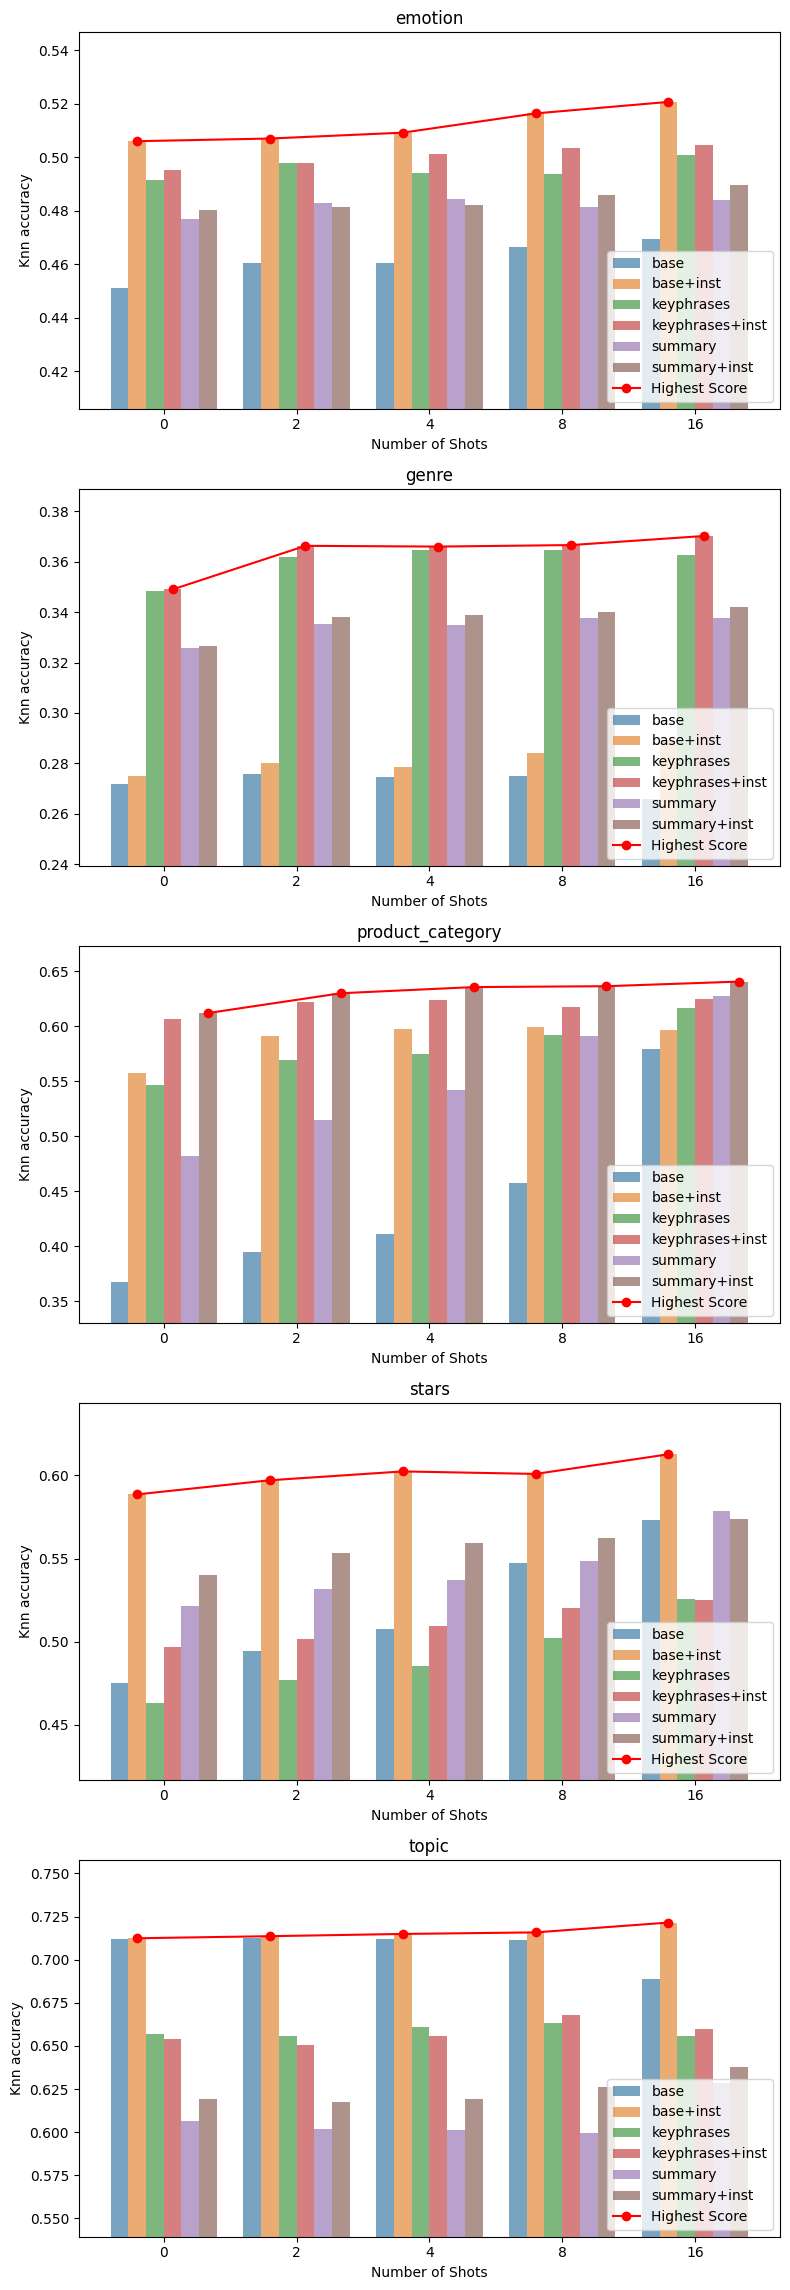

In [11]:
# for variant in ["avg", "max"]:
for variant in ["avg"]:
    # read df
    # fewshot_results_path = Path(f"visualizations/paper_results_{suffix}_{variant}.csv")
    fewshot_results_path = Path(f"visualizations/paper_results.csv")
    df = pd.read_csv(fewshot_results_path)

    # Get all unique label columns
    label_columns = df['label_column'].unique()

    # Create subplots
    fig, axes = plt.subplots(len(label_columns), 1, figsize=(8, 5 * len(label_columns)))
    if len(label_columns) == 1:
        axes = [axes]  # Ensure axes is always iterable
    else:
        axes = axes.flatten() # Flatten the 2D array of axes to easily iterate

    for i, label_column in enumerate(label_columns):
        ax = axes[i]
        
        scores = df[df['label_column'] == label_column]

        # Find the highest score per num_shots
        highest_scores = scores.groupby('num_shots')[score_column].max().reset_index()

        # Create the barplot
        barplot = sns.barplot(data=scores, x='num_shots', y=score_column, hue='experiment', alpha=0.66, ax=ax)

        # Get x-axis positions for the bars with the highest scores
        highest_positions = []
        for num_shot in highest_scores['num_shots']:
            for patch in barplot.patches:
                if patch.get_height() == highest_scores.loc[highest_scores['num_shots'] == num_shot, score_column].values[0]:
                    highest_positions.append(patch.get_x() + patch.get_width() / 2)
                    break

        # Add the line plot for highest scores
        ax.plot(highest_positions, highest_scores[score_column], marker='o', color='red', label='Highest Score')

        # Customize the plot
        ax.set_title(f'{label_column}')
        ax.set_xlabel('Number of Shots')
        ax.set_ylabel(score_column.replace('_', ' ').capitalize())
        ax.set_ylim([scores[score_column].min() * 0.9, scores[score_column].max() * 1.05])
        ax.legend(loc='lower right')


    # Hide any unused subplots
    for i in range(len(label_columns), len(axes)):
        fig.delaxes(axes[i])

    # Add a single title for the whole figure and adjust layout
    # fig.suptitle('Few-shot Learning Evaluation for Different Datasets', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    # plt.savefig(visualizations_path / f"paper_results_{suffix}_{variant}.png", dpi=300, bbox_inches='tight')
    plt.savefig(visualizations_path / f"paper_results.png", dpi=300, bbox_inches='tight')

### 4. Line Plot

In [67]:
line_csv = Path(f"visualizations/paper_results_fewshot.csv")
df = pd.read_csv(line_csv)

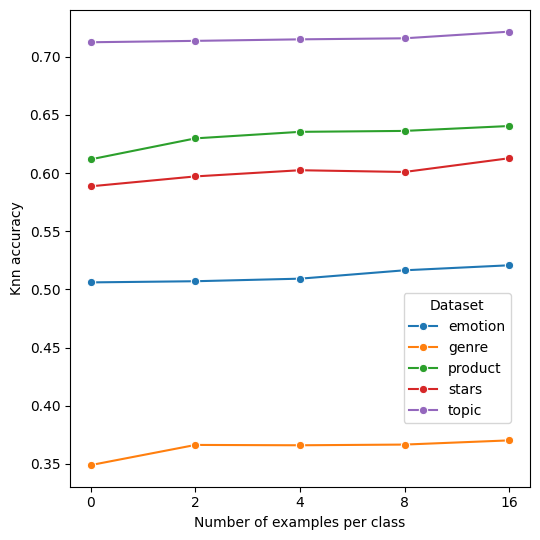

In [74]:
# Convert num_shots to string for categorical axis
df['num_shots_str'] = df['num_shots'].astype(str)
shot_order = ['0', '2', '4', '8', '16'] if set(df['num_shots_str']) == set(['0', '2', '4', '8', '16']) else sorted(df['num_shots_str'].unique(), key=int)

fig, ax = plt.subplots(figsize=(5.5, 5.5))
sns.lineplot(
    data=df,
    x='num_shots_str',
    y=score_column,
    hue='label_column',
    marker='o',         # Use the same marker for all lines
    dashes=False,
    ax=ax
)
ax.set_xticks(shot_order)
ax.set_xlabel('Number of examples per class')
ax.set_ylabel(score_column.replace('_', ' ').capitalize())
ax.legend(
    title='Dataset',
    loc='upper left',
    bbox_to_anchor=(0.71, 0.42)
)
plt.tight_layout()

In [ ]:
df['num_shots_cat'] = pd.Categorical(df['num_shots'], ordered=True)

# rename values 

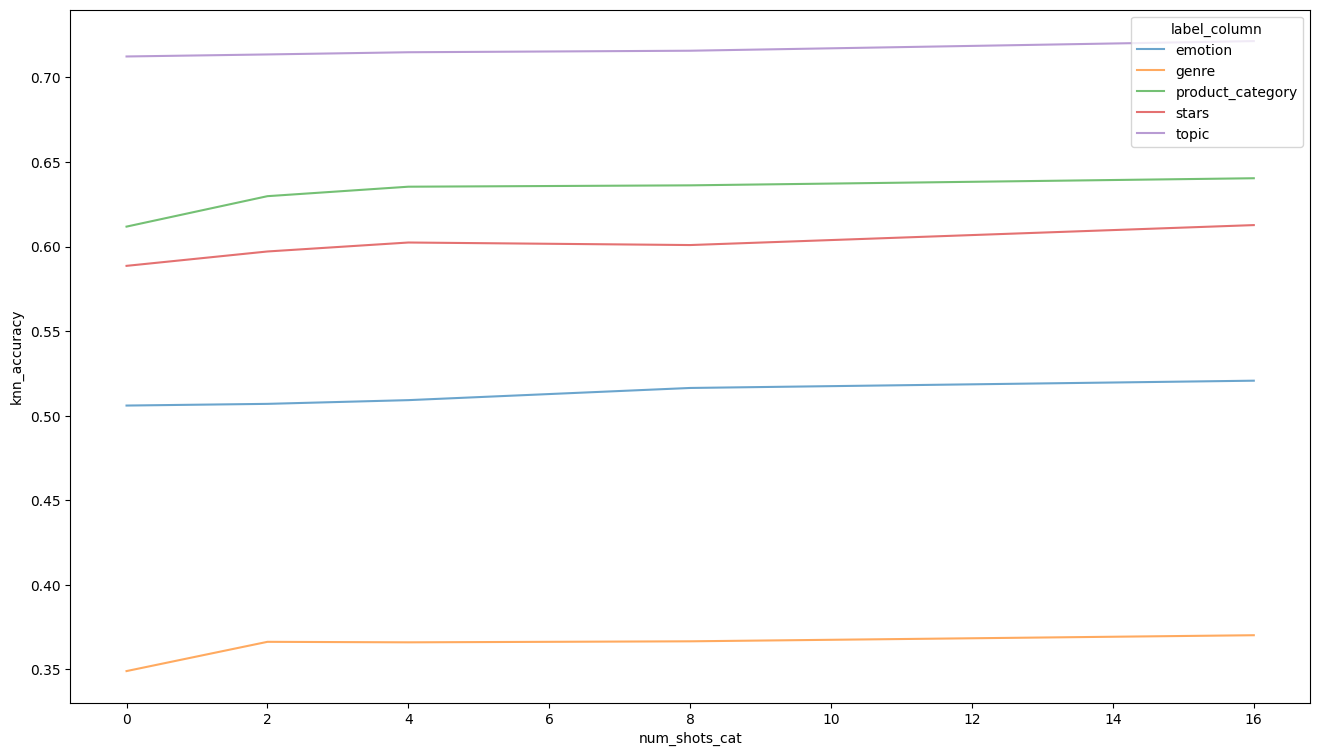

In [27]:
# Create the lineplot
fig, ax = plt.subplots(figsize=(16, 9))
lineplot = sns.lineplot(data=df, x='num_shots_cat', y=score_column, hue='label_column', alpha=0.66, ax=ax, markers='o')
